# MIP Complementary Filter

In [1]:
import sys
sys.path.append('..')

In [2]:
%matplotlib notebook  
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import scipy as sp
import scipy.signal as signal

/Users/mauricio/anaconda/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
from ctrl.system.tf import PID
from ctrl.block.linear import MIMO, ShortCircuit, Subtract, Differentiator
from ctrl.block.logger import Logger
from ctrl.block.nl import Abs
from ctrl.block.logic import CompareAbs, Trigger
from ctrl.system.tf import DTTF
from ctrl.system.ss import DTSS

from ctrl.block import Signal

In [4]:
from ctrl.client import Controller
HOST, PORT = "localhost", 9999
#HOST, PORT = "192.168.0.10", 9999
mip = Controller(host = HOST, port = PORT)

# Probe the controller

In [6]:
print(mip.info('all'))

> Controller with 6 device(s), 9 signal(s), 4 source(s), 2 sink(s), and 0 filter(s)
> devices
  1. encoder1[source]
  2. encoder2[source]
  3. clock[source]
  4. motor2[sink]
  5. motor1[sink]
  6. imu[source]
> signals
  1. clock
  2. duty
  3. encoder1
  4. encoder2
  5. is_running
  6. motor1
  7. motor2
  8. theta
  9. theta_dot
> sources
  1. clock[Clock, enabled] >> clock
  2. encoder1[Encoder, enabled] >> encoder1
  3. encoder2[Encoder, enabled] >> encoder2
  4. imu[Inclinometer, enabled] >> theta, theta_dot
> filters
> sinks
  1. motor1 >> motor1[Motor, enabled]
  2. motor2 >> motor2[Motor, enabled]



# Complementary Filter

In [7]:
Ts = 0.01
fc = 10
l = 2 * math.pi * fc
a = math.exp(-l*Ts)

Af = np.array([[a]])
Bf = np.array([[1-a,(1-a)/l]])
Cf = np.array([[1],[0]])
Df = np.array([[0,0],[0,1]])

fltr = DTSS(Af,Bf,Cf,Df)

mip.add_signal('imu_fltr')
mip.add_filter('fltr', 
               MIMO(fltr),
               ['theta','theta_dot'], 
               ['imu_fltr'])

In [8]:
mip.add_sink('logger', 
             Logger(), 
             ['clock',
              'theta','theta_dot','imu_fltr',
              'duty'])

In [9]:
print(mip.info('all'))

> Controller with 6 device(s), 10 signal(s), 4 source(s), 3 sink(s), and 1 filter(s)
> devices
  1. encoder1[source]
  2. encoder2[source]
  3. clock[source]
  4. motor2[sink]
  5. motor1[sink]
  6. imu[source]
> signals
  1. clock
  2. duty
  3. encoder1
  4. encoder2
  5. imu_fltr
  6. is_running
  7. motor1
  8. motor2
  9. theta
  10. theta_dot
> sources
  1. clock[Clock, enabled] >> clock
  2. encoder1[Encoder, enabled] >> encoder1
  3. encoder2[Encoder, enabled] >> encoder2
  4. imu[Inclinometer, enabled] >> theta, theta_dot
> filters
  1. theta, theta_dot >> fltr[MIMO, enabled] >> imu_fltr
> sinks
  1. motor1 >> motor1[Motor, enabled]
  2. motor2 >> motor2[Motor, enabled]
  3. clock, theta, theta_dot, imu_fltr, duty >> logger[Logger, enabled]



In [16]:
mip.set_sink('logger',reset=True)
mip.set_source('clock',reset=True)
mip.set_source('imu',reset=True)
mip.set_filter('fltr',reset=True)
with mip:
    time.sleep(120)
log = mip.read_sink('logger')

In [17]:
clock = log[:,0]
theta = log[:,1]
theta_dot = log[:,2]
theta_fltr = log[:,3]
theta_dot_fltr = log[:,4]
duty = log[:,5]

<IPython.core.display.Javascript object>


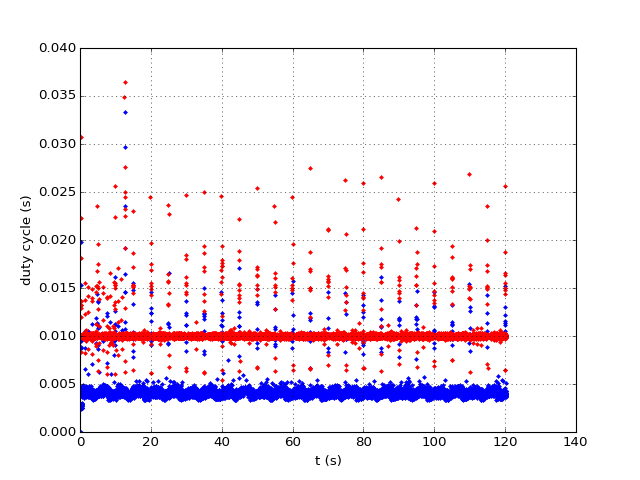

In [18]:
fig = plt.figure()

plt.plot(clock,duty,'.b',clock[:-1],clock[1:]-clock[:-1],'.r')
plt.xlabel('t (s)')
plt.ylabel('duty cycle (s)')
plt.grid()
#plt.xlim(0,1)

<IPython.core.display.Javascript object>


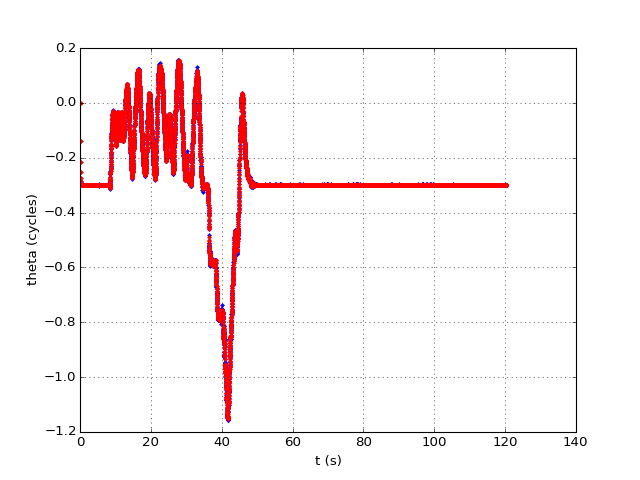

In [19]:
fig = plt.figure()

plt.plot(clock,theta,'.b',clock,theta_fltr,'.r')
plt.xlabel('t (s)')
plt.ylabel('theta (cycles)')
plt.grid()
#plt.xlim(0,1)

<IPython.core.display.Javascript object>


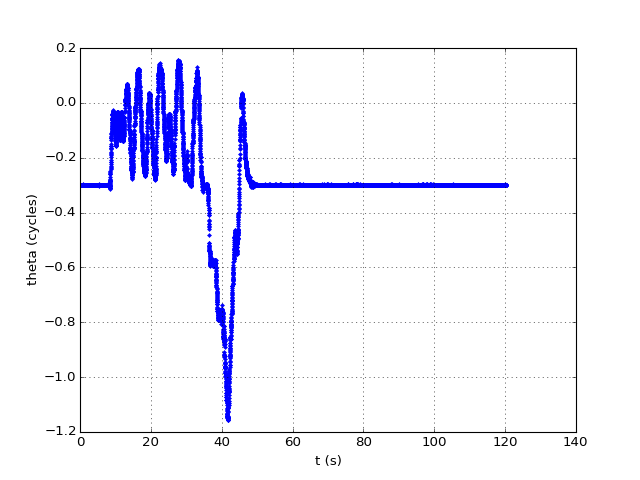

In [20]:
fig = plt.figure()

plt.plot(clock,theta,'.b')
plt.xlabel('t (s)')
plt.ylabel('theta (cycles)')
plt.grid()
#plt.xlim(0,1)

<IPython.core.display.Javascript object>


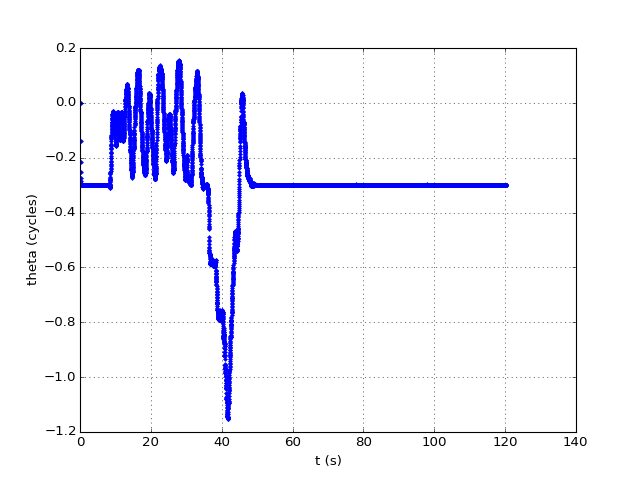

In [21]:
fig = plt.figure()

plt.plot(clock,theta_fltr,'.')

plt.xlabel('t (s)')
plt.ylabel('theta (cycles)')
plt.grid()
#plt.xlim(0,1)